In [11]:
from google.colab import drive
drive.mount('/content/drive')

#data_integration_file_path="/content/drive/MyDrive/DS_project/Data/5_Inter-cohort_preprocessing/5.5Multi-omics_integration/"

data_integration_file_path="/content/drive/MyDrive/DS_project/Data/5_Inter-cohort_preprocessing/5.5Multi-omics_integration/Z_output/"

data_cluster_file_path= "/content/drive/MyDrive/DS_project/Data/6_Unsupervised_clustering/kmeans_30mixed/"

data_clinical_file_path= "/content/drive/MyDrive/DS_project/Data/9_Biological_Interpretation/9.1_Cluster_Annotation/"

data_annotation_file_path="/content/drive/MyDrive/DS_project/Data/9_Biological_Interpretation/9.1_Cluster_Annotation/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pickle
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import chi2_contingency, fisher_exact, kruskal, f_oneway
import seaborn as sns

# Comparison with known clinical and molecular variables


Clusters will be compared against known variables such as age, sex, tumour grade or IDH mutation status.
- The latent space obtained from integrated multi-omics data will be used for cluster visualisation, e.g. PCA, t-SNE, UMAP.
- Samples will be coloured by known variables.


- Statistical associations between clusters and variables will be tested using:
  - Chi-square (parametric) or Fisher’s exact test (non-parametric) for categorical variables, e.g. sex
  - ANOVA (parametric) or Kruskal-Wallis test (non-parametric) for continuous variables, e.g. age
  - (Optional) Post hoc test, e.g. Tukey’s HSD (parametric) or Dunn’s test (non-parametric), may be applied when pairwise comparisons are needed.


#### merge latent files

In [13]:
'''
with open(data_integration_file_path + 'train_latent_output.pickle', 'rb') as f:
  train_latent_output = pickle.load(f)

with open(data_integration_file_path + 'val_latent_output.pickle', 'rb') as f:
  val_latent_output = pickle.load(f)

with open(data_integration_file_path + 'external_test_latent_output.pickle', 'rb') as f:
  external_test_latent_output = pickle.load(f)

with open(data_integration_file_path + 'internal_test_latent_output.pickle', 'rb') as f:
  internal_test_latent_output = pickle.load(f)
'''
with open(data_integration_file_path + '30mixed_train_latent_output.pickle', 'rb') as f:
  train_latent_output = pickle.load(f)

with open(data_integration_file_path + '30mixed_val_latent_output.pickle', 'rb') as f:
  val_latent_output = pickle.load(f)

with open(data_integration_file_path + '30mixed_internal_test_latent_output.pickle', 'rb') as f:
  internal_test_latent_output = pickle.load(f)

with open(data_integration_file_path + '30mixed_external_test_latent_output.pickle', 'rb') as f:
  external_test_latent_output = pickle.load(f)



datasets = {
  "train": train_latent_output,
  "val": val_latent_output,
  "internal_test": internal_test_latent_output,
  "external_test": external_test_latent_output
}


GBM = {
  "train": pd.DataFrame(),
  "val": pd.DataFrame(),
  "internal_test": pd.DataFrame(),
  "external_test": pd.DataFrame()
}

LGG = {
  "train": pd.DataFrame(),
  "val": pd.DataFrame(),
  "internal_test": pd.DataFrame(),
  "external_test": pd.DataFrame()
}

for set_name, data_list in datasets.items():
  for sample in data_list:
    sample_id = sample['sample_id']
    label = sample['label']  # 'GBM' or 'LGG'
    vector = sample['latent_vector']

    df_row = pd.DataFrame([vector], columns=[f"Factor{i+1}" for i in range(len(vector))], index=[sample_id])

    if label == 'GBM':
      GBM[set_name] = pd.concat([GBM[set_name], df_row])
    elif label == 'LGG':
      LGG[set_name] = pd.concat([LGG[set_name], df_row])
    else:
      print(f"unknown: {label}, {sample_id}")

merged_datasets = {
  "train": pd.DataFrame(),
  "val": pd.DataFrame(),
  "internal_test": pd.DataFrame(),
  "external_test": pd.DataFrame()
}


for set_name in merged_datasets.keys():
  gbm_df = GBM[set_name].copy()
  lgg_df = LGG[set_name].copy()

  if not gbm_df.empty:
    gbm_df['label'] = 'GBM'
    gbm_df['set'] = set_name
  if not lgg_df.empty:
    lgg_df['label'] = 'LGG'
    lgg_df['set'] = set_name

  merged_datasets[set_name] = pd.concat([gbm_df, lgg_df])

for name, df in merged_datasets.items():
  print(f"\n=== {name.upper()} ===")
  print(df.head(2))
  print("Shape:", df.shape)
  print("Label counts:\n", df['label'].value_counts())



=== TRAIN ===
                   Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
TCGA-02-0001-01C -0.105403  0.246711 -1.446588  9.333261  0.342465 -1.273676   
TCGA-02-0003-01A  0.237409  0.860601 -1.402766  0.525630  0.796524 -2.208254   

                   Factor7   Factor8   Factor9  Factor10  ...  Factor23  \
TCGA-02-0001-01C -0.030195  2.417586  0.240738 -1.224427  ...  0.288195   
TCGA-02-0003-01A -0.144449 -1.191715  0.061558  0.538526  ... -0.012136   

                  Factor24  Factor25  Factor26  Factor27  Factor28  Factor29  \
TCGA-02-0001-01C  0.422184 -0.576399 -1.177028   0.75724  5.119397 -0.543805   
TCGA-02-0003-01A  0.303736 -0.538899  0.285158   0.44576 -4.284283  2.412422   

                  Factor30  label    set  
TCGA-02-0001-01C -1.035246    GBM  train  
TCGA-02-0003-01A  0.770632    GBM  train  

[2 rows x 32 columns]
Shape: (605, 32)
Label counts:
 label
LGG    312
GBM    293
Name: count, dtype: int64

=== VAL ===
                   Factor1

#### merge clinical data

In [14]:
clinical_GBM = pd.read_csv(data_annotation_file_path + 'clinical_data_GBM_withIDH_dataset.tsv', sep='\t')

clinical_LGG = pd.read_csv(data_annotation_file_path + 'clinical_data_LGG_withIDH_dataset.tsv', sep='\t')

clinical_GBM["disease_type"] = "GBM"
clinical_GBM["neoplasm_histologic_grade"] = "G4"
clinical_LGG["disease_type"] = "LGG"

clinical_combined = pd.concat(
    [clinical_GBM, clinical_LGG],
    axis=0,
    join='outer',
    ignore_index=True
)

## get updated dataset information
clinical_combined = clinical_combined.drop(columns=['data_set_information'])
dataset_map = {}
for set_name, df in merged_datasets.items():
  for sample_id in df.index:
      dataset_map[sample_id] = set_name.replace('_', ' ').title()
clinical_combined['data_set_information'] = clinical_combined['sample'].map(dataset_map)


In [15]:
clinical_combined.head()
#clinical_combined["data_set_information"].value_counts()

,bcr_patient_barcode,gender,age_at_initial_pathologic_diagnosis,days_to_death,days_to_last_followup,histological_type,prior_glioma,IDH1_status,IDH1_mutation,IDH2_status,IDH2_mutation,sample,disease_type,neoplasm_histologic_grade,tumor_location,supratentorial_localization,laterality,first_presenting_symptom,data_set_information
0,TCGA-02-0001,FEMALE,44.0,358.0,279.0,Untreated primary (de novo) GBM,NO,Unknown,NaN,NaN,NaN,TCGA-02-0001-01C,GBM,G4,NaN,NaN,NaN,NaN,Train
1,TCGA-02-0003,MALE,50.0,144.0,144.0,Untreated primary (de novo) GBM,NO,Wildtype,NaN,Wildtype,NaN,TCGA-02-0003-01A,GBM,G4,NaN,NaN,NaN,NaN,Train
2,TCGA-02-0004,MALE,59.0,345.0,345.0,Untreated primary (de novo) GBM,NO,Unknown,NaN,NaN,NaN,TCGA-02-0004-01A,GBM,G4,NaN,NaN,NaN,NaN,NaN
3,TCGA-02-0006,FEMALE,56.0,558.0,558.0,Untreated primary (de novo) GBM,NO,Unknown,NaN,NaN,NaN,TCGA-02-0006-01B,GBM,G4,NaN,NaN,NaN,NaN,Val
4,TCGA-02-0007,FEMALE,40.0,705.0,705.0,Treated primary GBM,NO,Unknown,NaN,NaN,NaN,TCGA-02-0007-01A,GBM,G4,NaN,NaN,NaN,NaN,Train


### read cluster results

In [16]:

K = range(2,5)

label_dict = {}

dataset =['train','val','internal_test','external_test']

for k in K:
  k_dir = os.path.join(data_cluster_file_path, f"k_{k}")
  label_dict[k] = {}
  for d in dataset:
    # read cluster label
    #label_path = os.path.join(k_dir, f"{d}_cluster_labels_fulltrain.csv")
    label_path = os.path.join(k_dir, f"{d}_cluster_labels_consensus_complete.csv")
    label_df = pd.read_csv(label_path, index_col=0)
    label_dict[k][d] = label_df

## visualization by function (PCA/UMAP/t-SNE)

In [17]:
def plot_all_subsets_latent_embedding(
  merged_datasets,
  label_dict,
  clinical_df,
  k,
  method='PCA',
  color_by='cluster',
  clinical_var=None,
  figsize=(20, 5),
  random_state=42
):

  subsets = ['train', 'val', 'internal_test', 'external_test']
  fig, axes = plt.subplots(1, 4, figsize=figsize, sharex=False, sharey=False)

  for i, subset_name in enumerate(subsets):
    df = merged_datasets[subset_name].copy()
    cluster_labels = label_dict[subset_name].copy()
    cluster_labels = cluster_labels.rename(columns={cluster_labels.columns[0]: "Cluster"})
    clinical_df = clinical_df.drop_duplicates(subset="sample", keep="first")

    # Match index
    df = df.loc[df.index.intersection(cluster_labels.index)]
    cluster_labels = cluster_labels.loc[df.index]

    # Join cluster label
    df["Cluster"] = cluster_labels["Cluster"]

    # Join clinical variable if needed
    if color_by == "clinical" and clinical_var:
      clinical_subset = clinical_df.set_index("sample").loc[df.index]
      df[clinical_var] = clinical_subset[clinical_var].astype(str)

    # Get feature matrix
    feature_cols = [col for col in df.columns if col.startswith("Factor")]
    X = df[feature_cols].values

    # Dimensionality reduction
    if method.upper() == 'PCA':
      reducer = PCA(n_components=2, random_state=random_state)
    elif method.upper() == 'UMAP':
      reducer = UMAP(n_components=2, random_state=random_state)
    elif method.upper() == 'TSNE':
      reducer = TSNE(n_components=2, random_state=random_state)
    else:
      raise ValueError("Invalid method")

    embedding = reducer.fit_transform(X)
    df["Dim1"] = embedding[:, 0]
    df["Dim2"] = embedding[:, 1]

    # Plot on subplot
    ax = axes[i]
    if color_by == "cluster":
      sns.scatterplot(data=df, x="Dim1", y="Dim2", hue="Cluster", ax=ax, palette="tab10", s=50)
      ax.set_title(f"{subset_name} | K={k} | by Cluster")
    elif color_by == "clinical" and clinical_var:
      sns.scatterplot(data=df, x="Dim1", y="Dim2", hue=clinical_var, ax=ax, palette="Set2", s=50)
      ax.set_title(f"{subset_name} | by {clinical_var}")
    else:
      raise ValueError("Invalid color_by")

    ax.set_xlabel("Dim1")
    ax.set_ylabel("Dim2")

  plt.suptitle(f"{method.upper()} projection for {color_by}", fontsize=16)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


## visualization by cluster

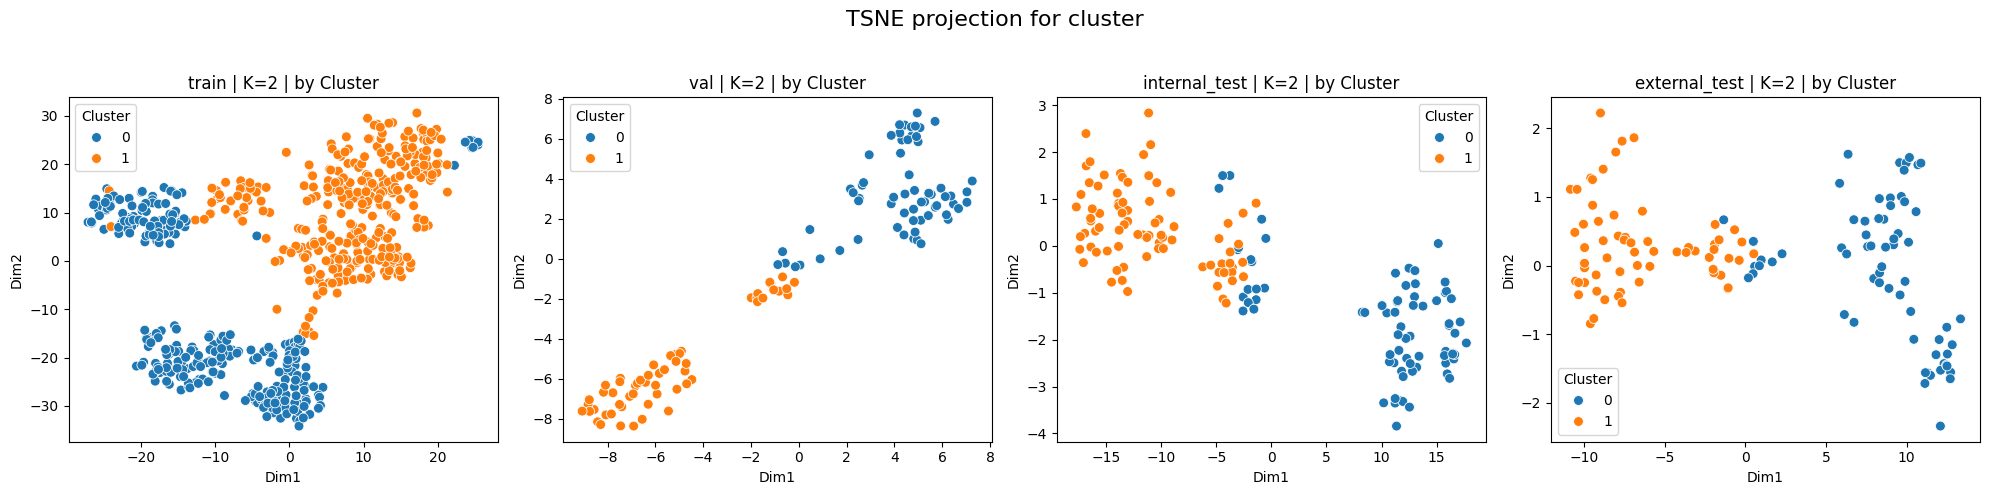

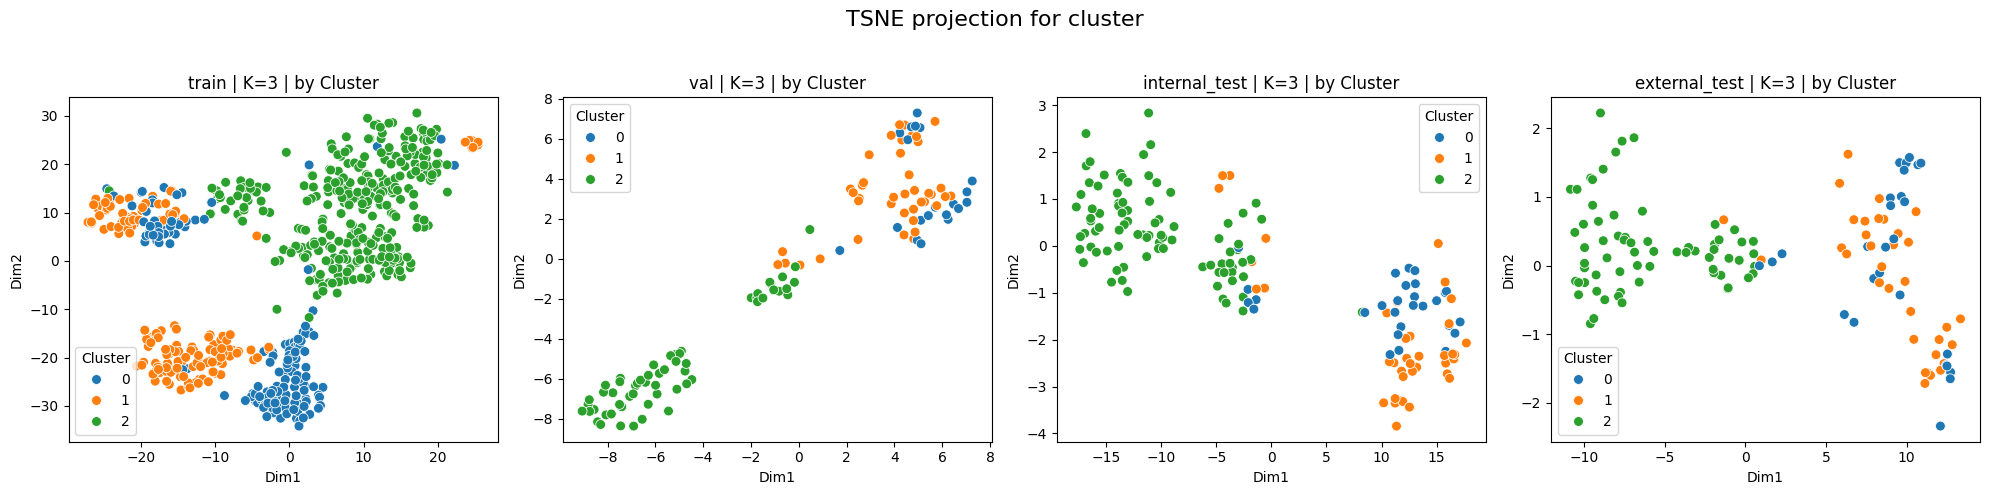

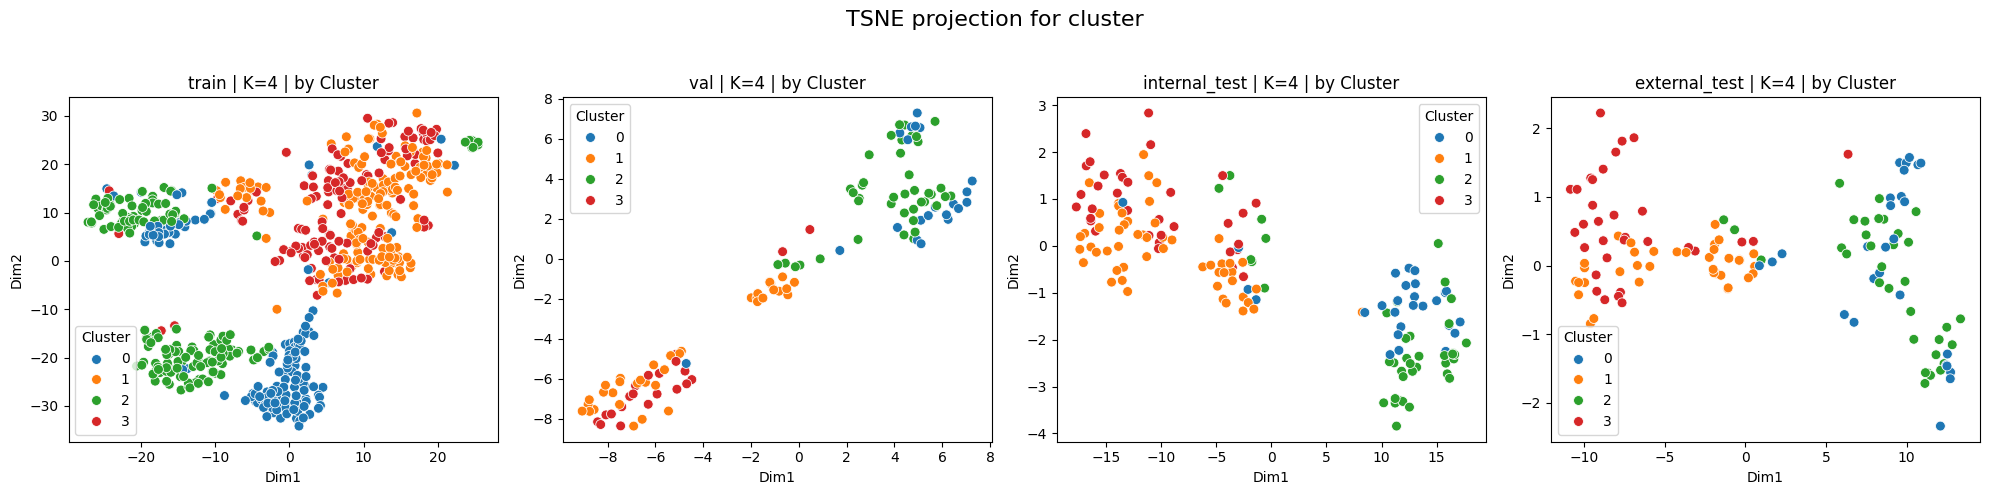

In [18]:
import warnings
warnings.filterwarnings("ignore", message="n_jobs value 1 overridden to 1")

K=range(2,5)

for k in K:
  plot_all_subsets_latent_embedding(
    merged_datasets=merged_datasets,
    label_dict=label_dict[k],
    clinical_df=clinical_combined,
    k=k,
    method='TSNE',
    color_by='cluster',
    random_state=42
  )


## visualization by IDH1_status

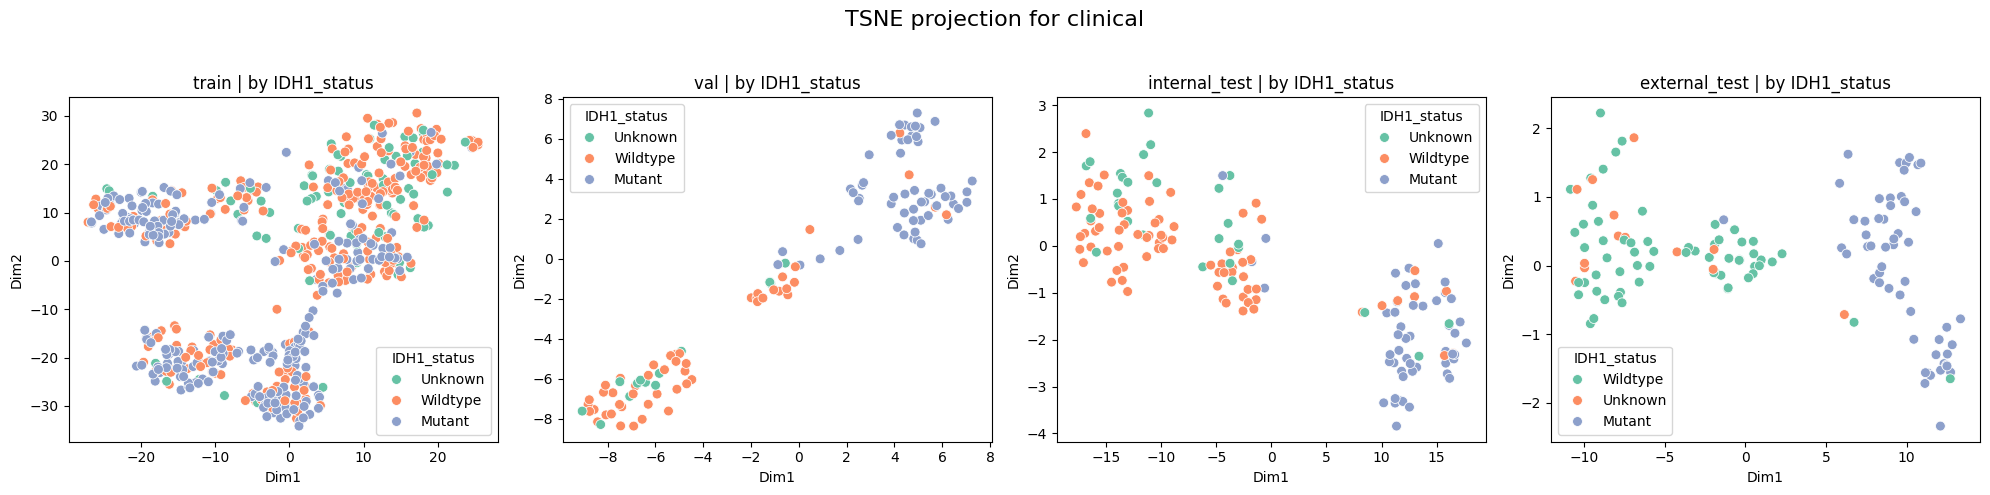

In [19]:
plot_all_subsets_latent_embedding(
  merged_datasets=merged_datasets,
  label_dict=label_dict[k],
  clinical_df=clinical_combined,
  k=2,
  method='TSNE',
  color_by='clinical',
  clinical_var='IDH1_status',
  random_state=42
)

## visualization by IDH2_status

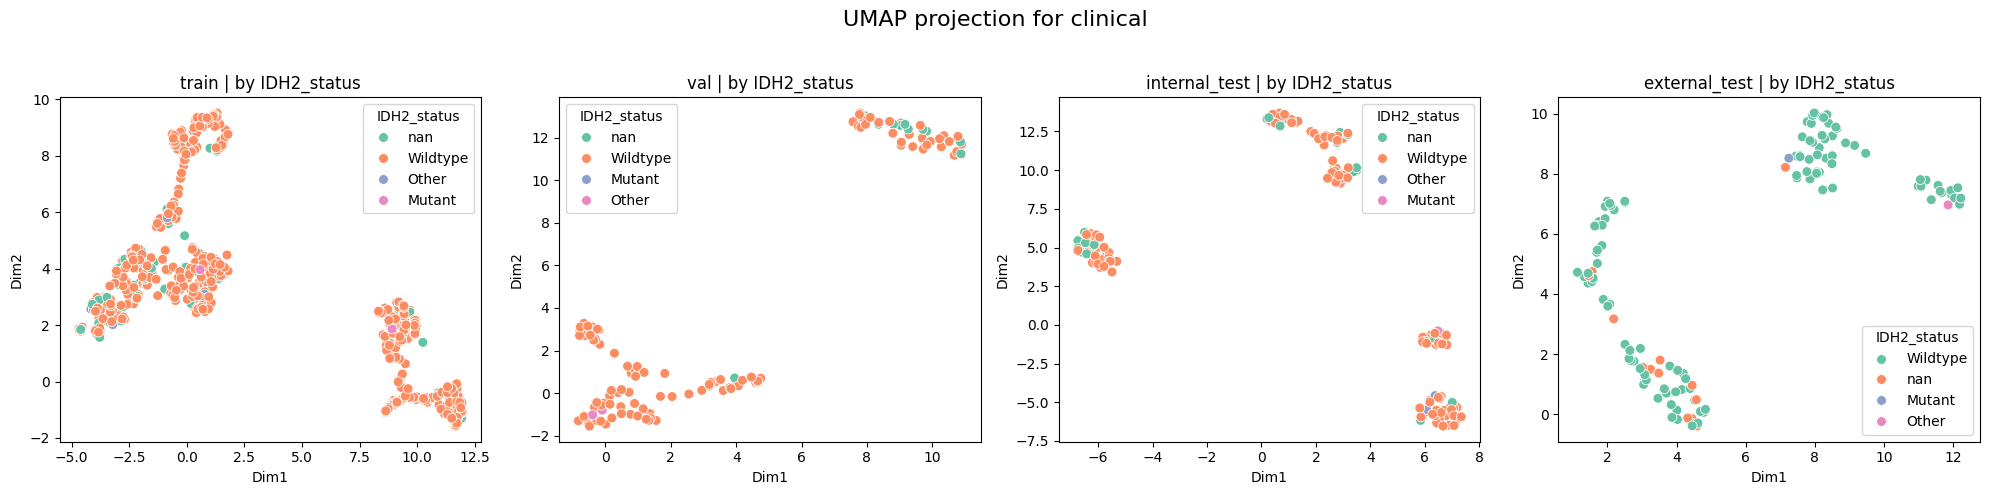

In [20]:
plot_all_subsets_latent_embedding(
  merged_datasets=merged_datasets,
  label_dict=label_dict[k],
  clinical_df=clinical_combined,
  k=2,
  method='UMAP',
  color_by='clinical',
  clinical_var='IDH2_status',
  random_state=42
)

## visualization by disease type

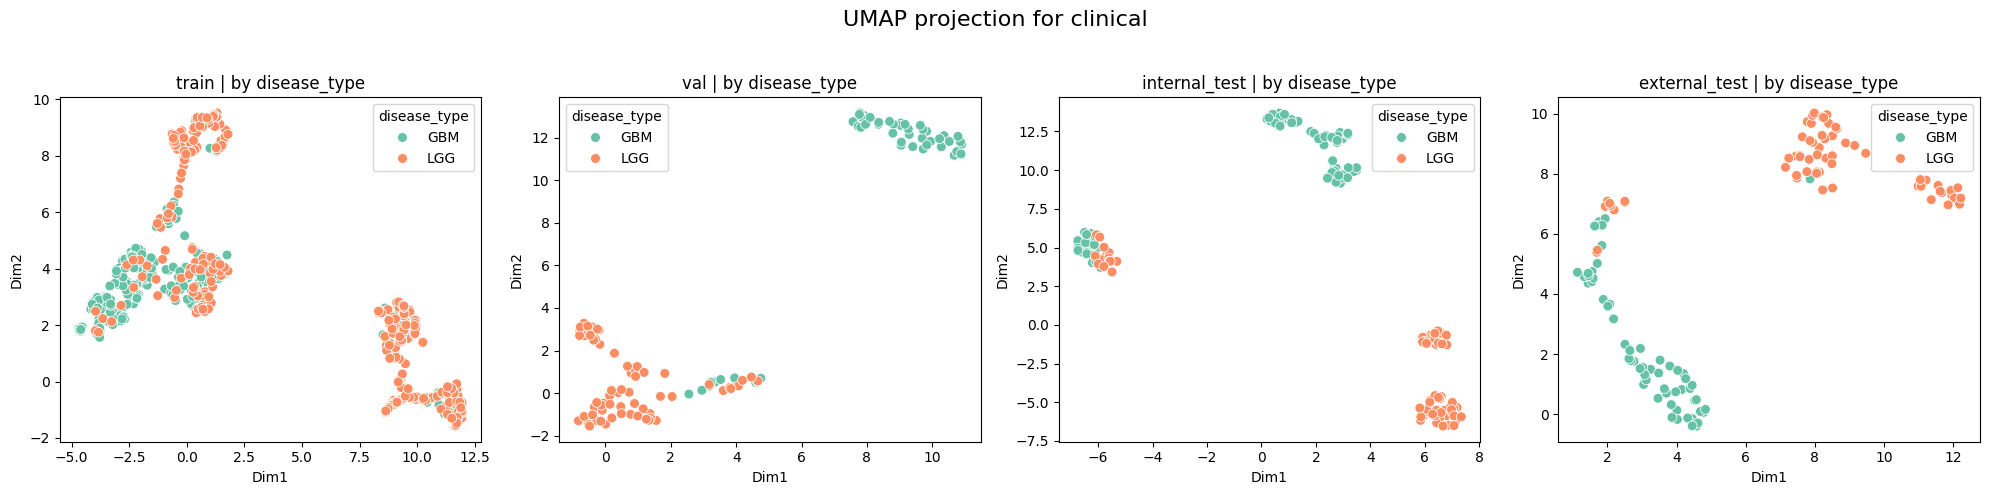

In [21]:
plot_all_subsets_latent_embedding(
  merged_datasets=merged_datasets,
  label_dict=label_dict[k],
  clinical_df=clinical_combined,
  k=2,
  method='UMAP',
  color_by='clinical',
  clinical_var='disease_type',
  random_state=42
)

## visualization by grade

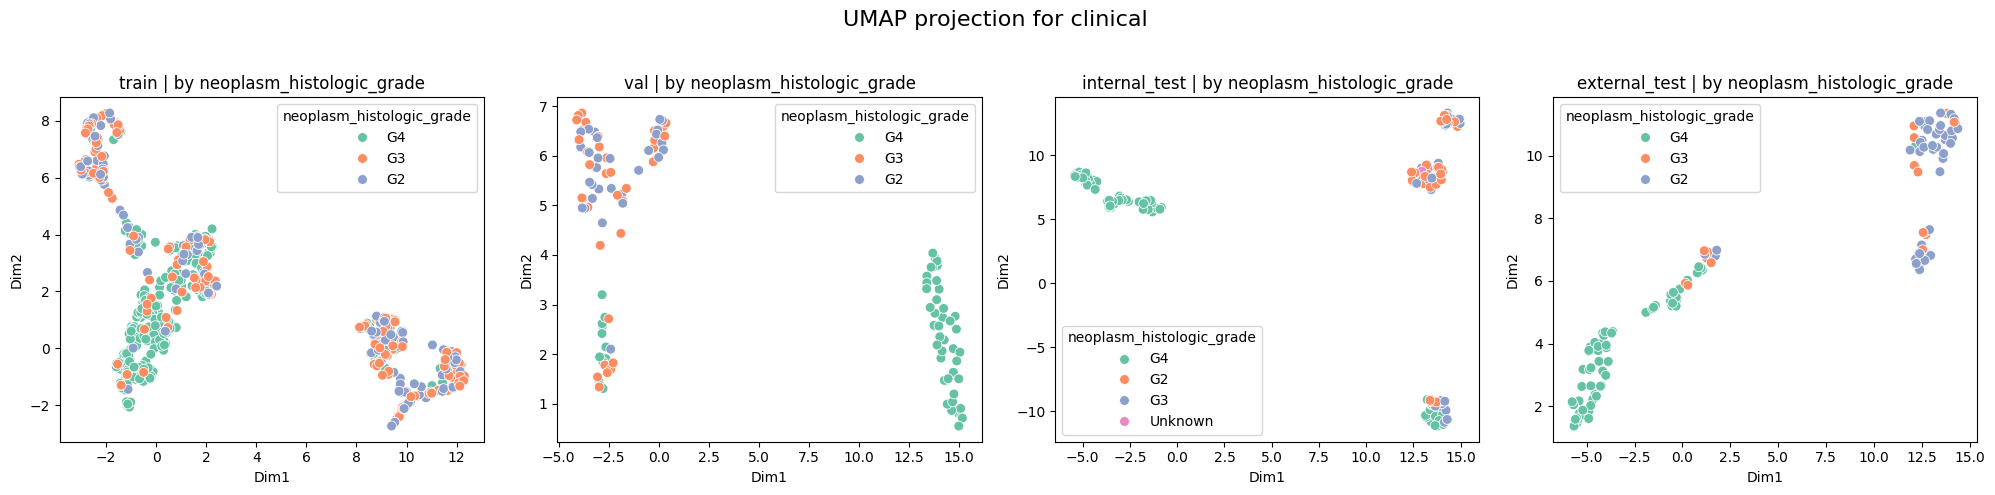

In [22]:

plot_all_subsets_latent_embedding(
  merged_datasets=merged_datasets,
  label_dict=label_dict[k],
  clinical_df=clinical_combined,
  k=2,
  method='UMAP',
  color_by='clinical',
  clinical_var='neoplasm_histologic_grade',
  random_state=1
)

## Statistics


### Chi-square /Fisher's exact test

for categorical variables:
- sex
- IDH1_status
- disease_type (GBM/LGG)
- histological_type

In [23]:
def test_categorical_association(df, var1, var2, method ,threshold=5):
  contingency = pd.crosstab(df[var1], df[var2])
  results = {}

  # perform Chi-square
  chi2, p_chi2, dof, expected = chi2_contingency(contingency, correction=True, lambda_=None) #Pearson's Chi-square
  p_value = p_chi2
  method = "chi2"
  # perform Fisher only if 2x2 and expected frequency <5
  if contingency.shape == (2, 2) and (expected < threshold).any():
    oddsratio, p_fisher = fisher_exact(contingency.values, alternative='two-sided')
    expected = contingency.values.copy()
    method = "fisher"
    p_value = p_fisher

  return {
    "test_used": method,
    "p_value": p_value,
    "contingency_table": contingency,
    "expected_freq": expected
  }

def format_test_result(result):
  print(f"\n Test Result Summary:")
  print(f"----------------------------")
  print(f" Test used:        {result['test_used'].upper()}")
  print(f" P-value:          {result['p_value']:.4e}")
  print(f"\n Contingency Table:")
  print(result['contingency_table'].to_string())


  print(f"\n Expected Frequencies:")
  print(pd.DataFrame(result['expected_freq'],
                      index=result['contingency_table'].index,
                      columns=result['contingency_table'].columns).round(2).to_string())

In [24]:
test_summary = pd.DataFrame(columns=["k","var","test_used", "p_value"])
var = ['gender','IDH1_status','disease_type','histological_type']

for k in K:
  #print(f"\n=== K={k} ===")
  all_label_list = []
  for subset_name, df in label_dict[k].items():
    df = df.copy()
    df["sample"] = df.index
    all_label_list.append(df.reset_index(drop=True))

  combined_label = pd.concat(all_label_list, axis=0).reset_index(drop=True)
  combined_df = pd.merge(clinical_combined, combined_label, on='sample', how='inner')

  for v in var:
    result = test_categorical_association(combined_df, "cluster", v ,method="fisher", threshold=5)
    test_summary.loc[len(test_summary)] = [k,v,result["test_used"], result["p_value"]]

print(test_summary)


    k                var test_used        p_value
0   2             gender      chi2   1.331718e-01
1   2        IDH1_status      chi2   3.428911e-73
2   2       disease_type      chi2  6.120399e-104
3   2  histological_type      chi2  1.142216e-100
4   3             gender      chi2   5.229860e-01
5   3        IDH1_status      chi2   4.081236e-79
6   3       disease_type      chi2  6.785047e-103
7   3  histological_type      chi2  2.405261e-100
8   4             gender      chi2   6.706489e-03
9   4        IDH1_status      chi2   3.988672e-75
10  4       disease_type      chi2  4.976626e-102
11  4  histological_type      chi2   2.797854e-97


/tmp/ipython-input-32-832268206.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_k, x="var", y="-log10(p)", palette="viridis")


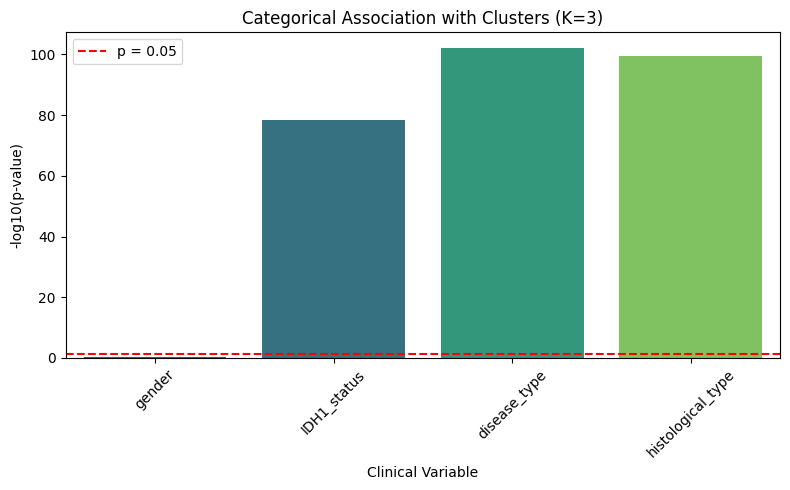

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

selected_k = 3

df_k = test_summary[test_summary["k"] == selected_k].copy()
df_k["-log10(p)"] = -np.log10(df_k["p_value"])

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df_k, x="var", y="-log10(p)", palette="viridis")

# p = 0.05
plt.axhline(-np.log10(0.05), color="red", linestyle="--", label="p = 0.05")


plt.title(f"Categorical Association with Clusters (K={selected_k})")
plt.xlabel("Clinical Variable")
plt.ylabel("-log10(p-value)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### ANOVA (parametric) / Kruskal-Wallis test (non-parametric)

for continuous variables
- age

#### check Normality (Shapiro-Wilk)




=== K = 2 ===
Cluster 0: Shapiro p = 0.0000 → <0.05
Cluster 1: Shapiro p = 0.0003 → <0.05


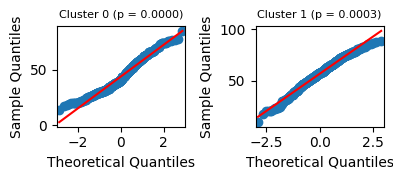


=== K = 3 ===
Cluster 0: Shapiro p = 0.0002 → <0.05
Cluster 1: Shapiro p = 0.0000 → <0.05
Cluster 2: Shapiro p = 0.0004 → <0.05


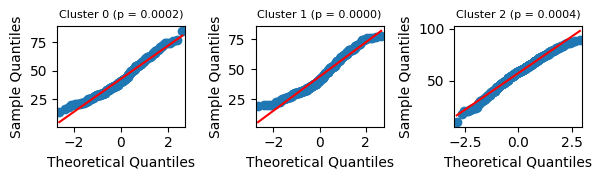


=== K = 4 ===
Cluster 0: Shapiro p = 0.0004 → <0.05
Cluster 1: Shapiro p = 0.0014 → <0.05
Cluster 2: Shapiro p = 0.0000 → <0.05
Cluster 3: Shapiro p = 0.0836 → p > 0.05 (accept Normality)


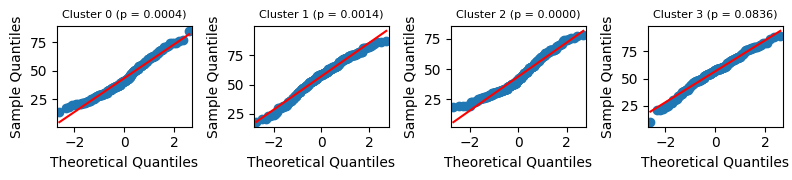

In [26]:
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro

for k in K:
    print(f"\n=== K = {k} ===")
    all_label_list = []

    for subset_name, df in label_dict[k].items():
        df = df.copy()
        df["sample"] = df.index
        all_label_list.append(df.reset_index(drop=True))

    combined_label = pd.concat(all_label_list, axis=0).reset_index(drop=True)
    combined_df = pd.merge(clinical_combined, combined_label, on='sample', how='inner')

    clusters = combined_df['cluster'].dropna().unique()
    n_clusters = len(clusters)

    n_cols = 5
    n_rows = math.ceil(n_clusters / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    axes = axes.flatten()

    for i, cluster_id in enumerate(sorted(clusters)):
        group = combined_df[combined_df['cluster'] == cluster_id]
        data = group['age_at_initial_pathologic_diagnosis'].dropna()

        # Shapiro-Wilk
        stat, p = shapiro(data)
        result = 'p > 0.05 (accept Normality)' if p > 0.05 else '<0.05'
        print(f"Cluster {cluster_id}: Shapiro p = {p:.4f} → {result}")

        sm.qqplot(data, line='s', ax=axes[i])
        axes[i].set_title(f"Cluster {cluster_id} (p = {p:.4f})",size=8)
        axes[i].set_xlabel("Theoretical Quantiles")
        axes[i].set_ylabel("Sample Quantiles")

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


#### check Homogeneity of variances

In [27]:
from scipy.stats import levene

for k in K:
    print(f"\n=== K = {k} ===")
    all_label_list = []

    for subset_name, df in label_dict[k].items():
        df = df.copy()
        df["sample"] = df.index
        all_label_list.append(df.reset_index(drop=True))

    combined_label = pd.concat(all_label_list, axis=0).reset_index(drop=True)
    combined_df = pd.merge(clinical_combined, combined_label, on='sample', how='inner')

    # Levene Test
    groups = [group['age_at_initial_pathologic_diagnosis'].dropna()
              for _, group in combined_df.groupby('cluster')]
    stat, p = levene(*groups)
    result = ' Homogeneous' if p > 0.05 else 'Heterogeneous'
    print(f"Levene’s Test for K={k}: p = {p:.4f} → {result}")



=== K = 2 ===
Levene’s Test for K=2: p = 0.2545 →  Homogeneous

=== K = 3 ===
Levene’s Test for K=3: p = 0.3161 →  Homogeneous

=== K = 4 ===
Levene’s Test for K=4: p = 0.5136 →  Homogeneous


#### ANOVA


=== K = 2 ===
ANOVA for age at K = 2: F = 202.6406, p = 0.0000 → significant (p < 0.05)
         count   mean    std
cluster                     
0          487  43.87  14.39
1          524  56.76  14.38


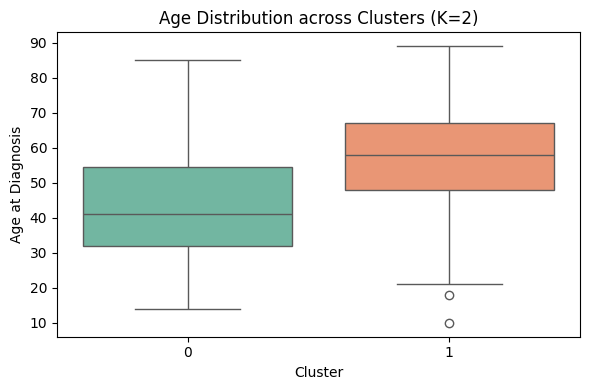


=== K = 3 ===
ANOVA for age at K = 3: F = 117.2012, p = 0.0000 → significant (p < 0.05)
         count   mean    std
cluster                     
0          223  42.97  14.53
1          265  43.90  14.24
2          523  57.15  14.05


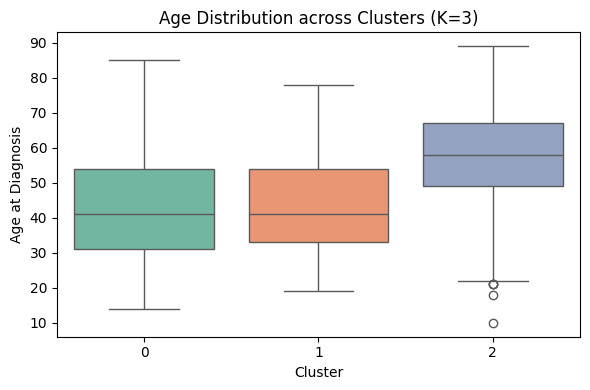


=== K = 4 ===
ANOVA for age at K = 4: F = 71.1984, p = 0.0000 → significant (p < 0.05)
         count   mean    std
cluster                     
0          218  43.61  14.84
1          305  57.08  14.26
2          274  43.92  14.03
3          214  56.80  14.30


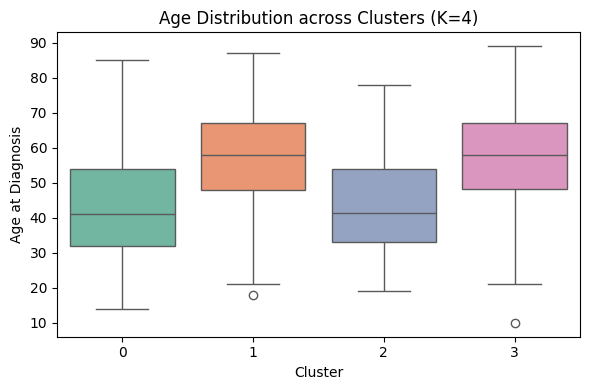

In [28]:
from scipy.stats import f_oneway

for k in K:
    print(f"\n=== K = {k} ===")
    all_label_list = []

    for subset_name, df in label_dict[k].items():
        df = df.copy()
        df["sample"] = df.index
        all_label_list.append(df.reset_index(drop=True))

    combined_label = pd.concat(all_label_list, axis=0).reset_index(drop=True)
    combined_df = pd.merge(clinical_combined, combined_label, on='sample', how='inner')

    age_groups = [
        group['age_at_initial_pathologic_diagnosis'].dropna()
        for _, group in combined_df.groupby('cluster')
    ]

    # ANOVA
    stat, p = f_oneway(*age_groups)

    result = "significant (p < 0.05)" if p < 0.05 else "non-significant (p ≥ 0.05)"
    print(f"ANOVA for age at K = {k}: F = {stat:.4f}, p = {p:.4f} → {result}")
    summary_age = combined_df.groupby('cluster')['age_at_initial_pathologic_diagnosis'].agg(
      count='count', mean='mean', std='std').round(2)
    print(summary_age)

    plt.figure(figsize=(6, 4))
    sns.boxplot(data=combined_df, x='cluster', y='age_at_initial_pathologic_diagnosis',palette='Set2',hue='cluster',legend=False)
    plt.title(f"Age Distribution across Clusters (K={k})")
    plt.xlabel("Cluster")
    plt.ylabel("Age at Diagnosis")
    plt.tight_layout()
    plt.show()



=== K = 2 ===
ANOVA for age at K = 2: F = 202.6406, p = 0.0000 → significant (p < 0.05)
         count   mean    std
cluster                     
0          487  43.87  14.39
1          524  56.76  14.38


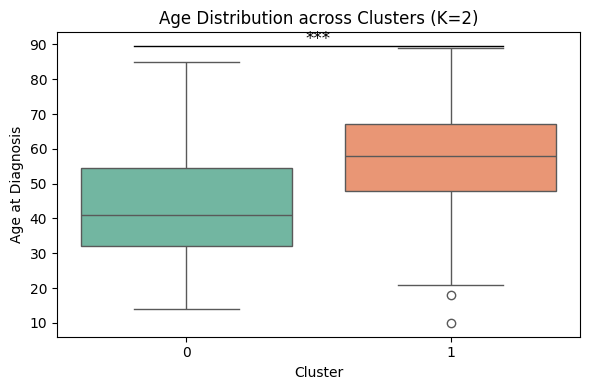


=== K = 3 ===
ANOVA for age at K = 3: F = 117.2012, p = 0.0000 → significant (p < 0.05)
         count   mean    std
cluster                     
0          223  42.97  14.53
1          265  43.90  14.24
2          523  57.15  14.05


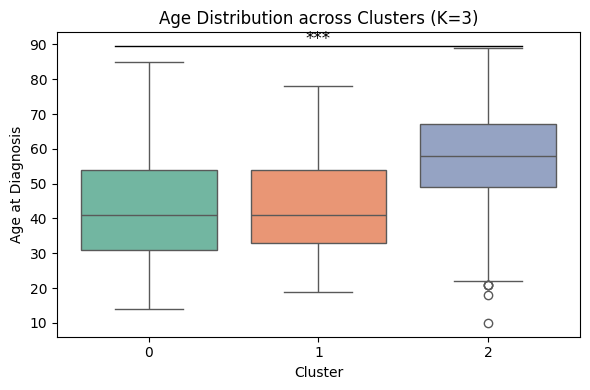


=== K = 4 ===
ANOVA for age at K = 4: F = 71.1984, p = 0.0000 → significant (p < 0.05)
         count   mean    std
cluster                     
0          218  43.61  14.84
1          305  57.08  14.26
2          274  43.92  14.03
3          214  56.80  14.30


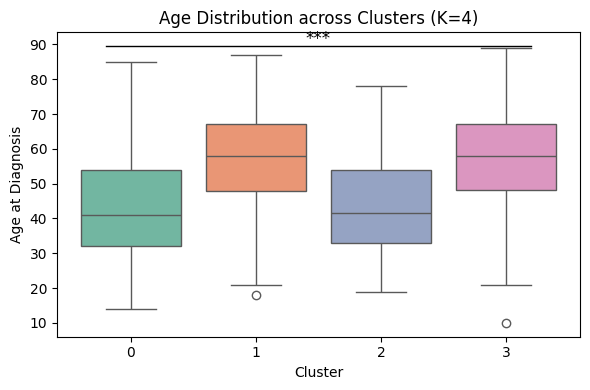

In [44]:
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

for k in K:
    print(f"\n=== K = {k} ===")
    all_label_list = []

    for subset_name, df in label_dict[k].items():
        df = df.copy()
        df["sample"] = df.index
        all_label_list.append(df.reset_index(drop=True))

    combined_label = pd.concat(all_label_list, axis=0).reset_index(drop=True)
    combined_df = pd.merge(clinical_combined, combined_label, on='sample', how='inner')

    age_groups = [
        group['age_at_initial_pathologic_diagnosis'].dropna()
        for _, group in combined_df.groupby('cluster')
    ]

    # ANOVA
    stat, p = f_oneway(*age_groups)

    result = "significant (p < 0.05)" if p < 0.05 else "non-significant (p ≥ 0.05)"
    print(f"ANOVA for age at K = {k}: F = {stat:.4f}, p = {p:.4f} → {result}")
    summary_age = combined_df.groupby('cluster')['age_at_initial_pathologic_diagnosis'].agg(
        count='count', mean='mean', std='std').round(2)
    print(summary_age)

    # Plot
    plt.figure(figsize=(6, 4))
    ax = sns.boxplot(
        data=combined_df,
        x='cluster',
        y='age_at_initial_pathologic_diagnosis',
        palette='Set2',
        hue='cluster',
        legend=False
    )

    plt.title(f"Age Distribution across Clusters (K={k})")
    plt.xlabel("Cluster")
    plt.ylabel("Age at Diagnosis")

    y_max = combined_df['age_at_initial_pathologic_diagnosis'].max()
    y_sig = y_max + 0.5

    if p < 0.001:
        sig_label = "***"
    elif p < 0.01:
        sig_label = "**"
    elif p < 0.05:
        sig_label = "*"
    else:
        sig_label = "ns"

    ax.plot([-0.2, len(combined_df['cluster'].unique()) - 0.8], [y_sig, y_sig], lw=1, c='black')
    ax.text(x=len(combined_df['cluster'].unique()) / 2 - 0.5, y=y_sig - 0.5, s=sig_label,
            ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()


#### Kruskal–Wallis


=== K = 2 ===
Kruskal-Wallis test: H = 169.9523, p = 0.0000 → significant

          count   mean    std
cluster                     
0          487  43.87  14.39
1          524  56.76  14.38


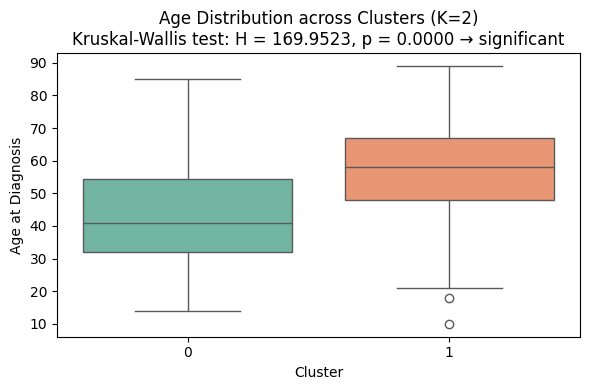


=== K = 3 ===
Kruskal-Wallis test: H = 193.2022, p = 0.0000 → significant

          count   mean    std
cluster                     
0          223  42.97  14.53
1          265  43.90  14.24
2          523  57.15  14.05


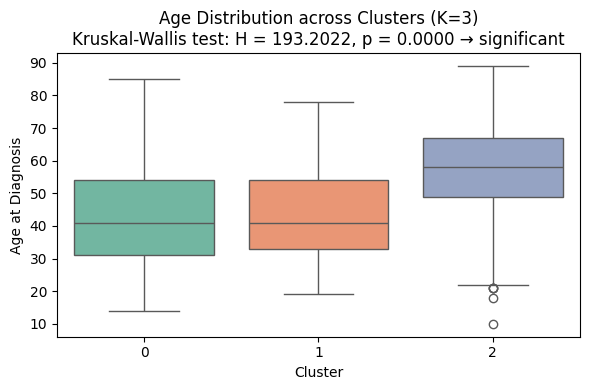


=== K = 4 ===
Kruskal-Wallis test: H = 178.5644, p = 0.0000 → significant

          count   mean    std
cluster                     
0          218  43.61  14.84
1          305  57.08  14.26
2          274  43.92  14.03
3          214  56.80  14.30


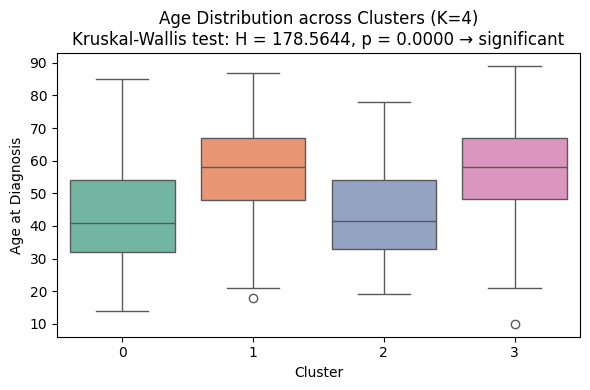

In [29]:
from scipy.stats import kruskal

def kruskal_age_by_cluster(df, cluster_col='cluster', age_col='age_at_initial_pathologic_diagnosis', k_val=None):
    print(f"\n=== K = {k_val} ===")

    grouped = df.dropna(subset=[cluster_col, age_col]).groupby(cluster_col)
    age_groups = [group[age_col].values for _, group in grouped]

    # Kruskal-Wallis
    stat, p = kruskal(*age_groups)

    result_str = f"Kruskal-Wallis test: H = {stat:.4f}, p = {p:.4f} → {'significant' if p < 0.05 else 'not significant'}"
    print(result_str)

    summary_df = grouped[age_col].agg(['count', 'mean', 'std']).round(2)
    print("\n", summary_df)

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=cluster_col, y=age_col, data=df, palette='Set2',hue=cluster_col,legend=False)
    plt.title(f"Age Distribution across Clusters (K={k_val})\n{result_str}")
    plt.xlabel("Cluster")
    plt.ylabel("Age at Diagnosis")
    plt.tight_layout()
    plt.show()

for k in K:
    all_label_list = []
    for subset_name, df in label_dict[k].items():
        df = df.copy()
        df["sample"] = df.index
        all_label_list.append(df.reset_index(drop=True))

    combined_label = pd.concat(all_label_list, axis=0).reset_index(drop=True)
    combined_df_k = pd.merge(clinical_combined, combined_label, on='sample', how='inner')

    kruskal_age_by_cluster(combined_df_k, k_val=k)

#### Dunn' s test

In [30]:
!pip install scikit-posthocs
import scikit_posthocs as sp


=== Dunn’s Posthoc Test | K = 2 ===

Pairwise p-values (Bonferroni corrected):

     0    1
0  1.0  0.0
1  0.0  1.0


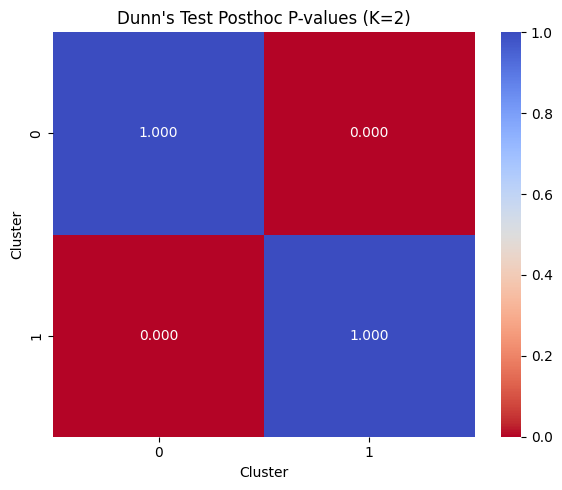


=== Dunn’s Posthoc Test | K = 3 ===

Pairwise p-values (Bonferroni corrected):

     0    1    2
0  1.0  1.0  0.0
1  1.0  1.0  0.0
2  0.0  0.0  1.0


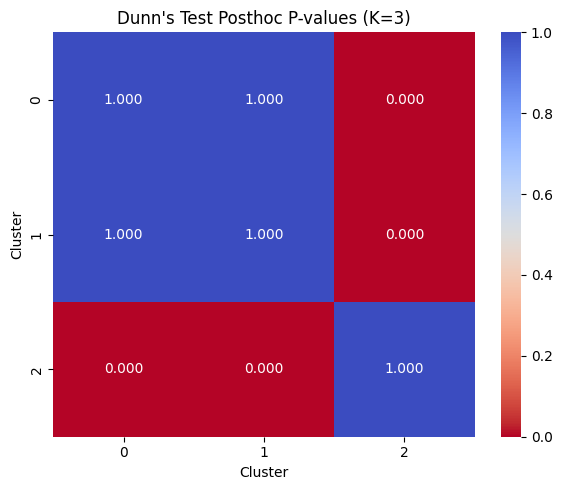


=== Dunn’s Posthoc Test | K = 4 ===

Pairwise p-values (Bonferroni corrected):

     0    1    2    3
0  1.0  0.0  1.0  0.0
1  0.0  1.0  0.0  1.0
2  1.0  0.0  1.0  0.0
3  0.0  1.0  0.0  1.0


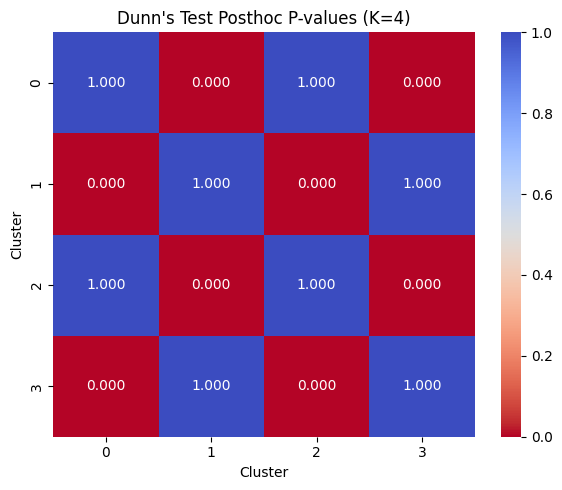

In [45]:
def dunn_posthoc_age(df, cluster_col='cluster', age_col='age_at_initial_pathologic_diagnosis', k_val=None):
    print(f"\n=== Dunn’s Posthoc Test | K = {k_val} ===")

    df_filtered = df.dropna(subset=[cluster_col, age_col])

    # Dunn's test with Bonferroni correction
    dunn_result = sp.posthoc_dunn(df_filtered, val_col=age_col, group_col=cluster_col, p_adjust='bonferroni')

    print("\nPairwise p-values (Bonferroni corrected):\n")
    print(dunn_result.round(4))

    plt.figure(figsize=(6, 5))
    sns.heatmap(dunn_result, annot=True, fmt=".3f", cmap="coolwarm_r", cbar=True)
    plt.title(f"Dunn's Test Posthoc P-values (K={k_val})")
    plt.xlabel("Cluster")
    plt.ylabel("Cluster")
    plt.tight_layout()
    plt.show()

for k in K:
    all_label_list = []
    for subset_name, df in label_dict[k].items():
        df = df.copy()
        df["sample"] = df.index
        all_label_list.append(df.reset_index(drop=True))

    combined_label = pd.concat(all_label_list, axis=0).reset_index(drop=True)
    combined_df_k = pd.merge(clinical_combined, combined_label, on='sample', how='inner')

    dunn_posthoc_age(combined_df_k, k_val=k)
